In [58]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
df = pd.read_csv("D:\\SETA\\ENERGY\\data\\ISEM_scraped_historical_data_raw.csv")

# drop duplicated columns with different names
df = df.T.drop_duplicates(keep="first").T
df = df.infer_objects()

df["Time Start (WET)"] = pd.to_datetime(df["Time Start (WET)"])
unseen = pd.read_csv("D:\\SETA\\ENERGY\\data\\ISEM_unseen_data.csv")
unseen["Time Start (WET)"] = pd.to_datetime(unseen["Time Start (WET)"])

# 1. Handling missing data

In [60]:
"""df["PREDICTION_TIME"] = df["Time Start (WET)"]
df["TARGET"] = df["DA Prices-IRELAND (IE) [EUR/MWh]"]
forecast_columns = list(df.columns[df.columns.str.contains("FORECAST")])
forecast_columns.append("PREDICTION_TIME")
forecast_columns.append("TARGET")
actual_columns = list(df.drop(forecast_columns, axis = 1).columns)"""

'df["PREDICTION_TIME"] = df["Time Start (WET)"]\ndf["TARGET"] = df["DA Prices-IRELAND (IE) [EUR/MWh]"]\nforecast_columns = list(df.columns[df.columns.str.contains("FORECAST")])\nforecast_columns.append("PREDICTION_TIME")\nforecast_columns.append("TARGET")\nactual_columns = list(df.drop(forecast_columns, axis = 1).columns)'

In [61]:
null = df.isna().sum().sort_values(ascending = False)
# filter out columns that more than 60% of them are null
null_qualify = list(null[null < df.shape[0] * 0.4].index)
df = df[null_qualify]
# remove constant columns
variance = df.var()
not_constant = list(variance[variance > 0].index)
not_constant.append("Time Start (WET)")
df = df[not_constant]
df.shape

C:\Users\DELL24H.VN\AppData\Local\Temp\ipykernel_11168\2476986365.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = df.var()


(42527, 161)

Next, we examine visualize the missing data to check if there is a pattern and come up with the handling strategy

<AxesSubplot:>

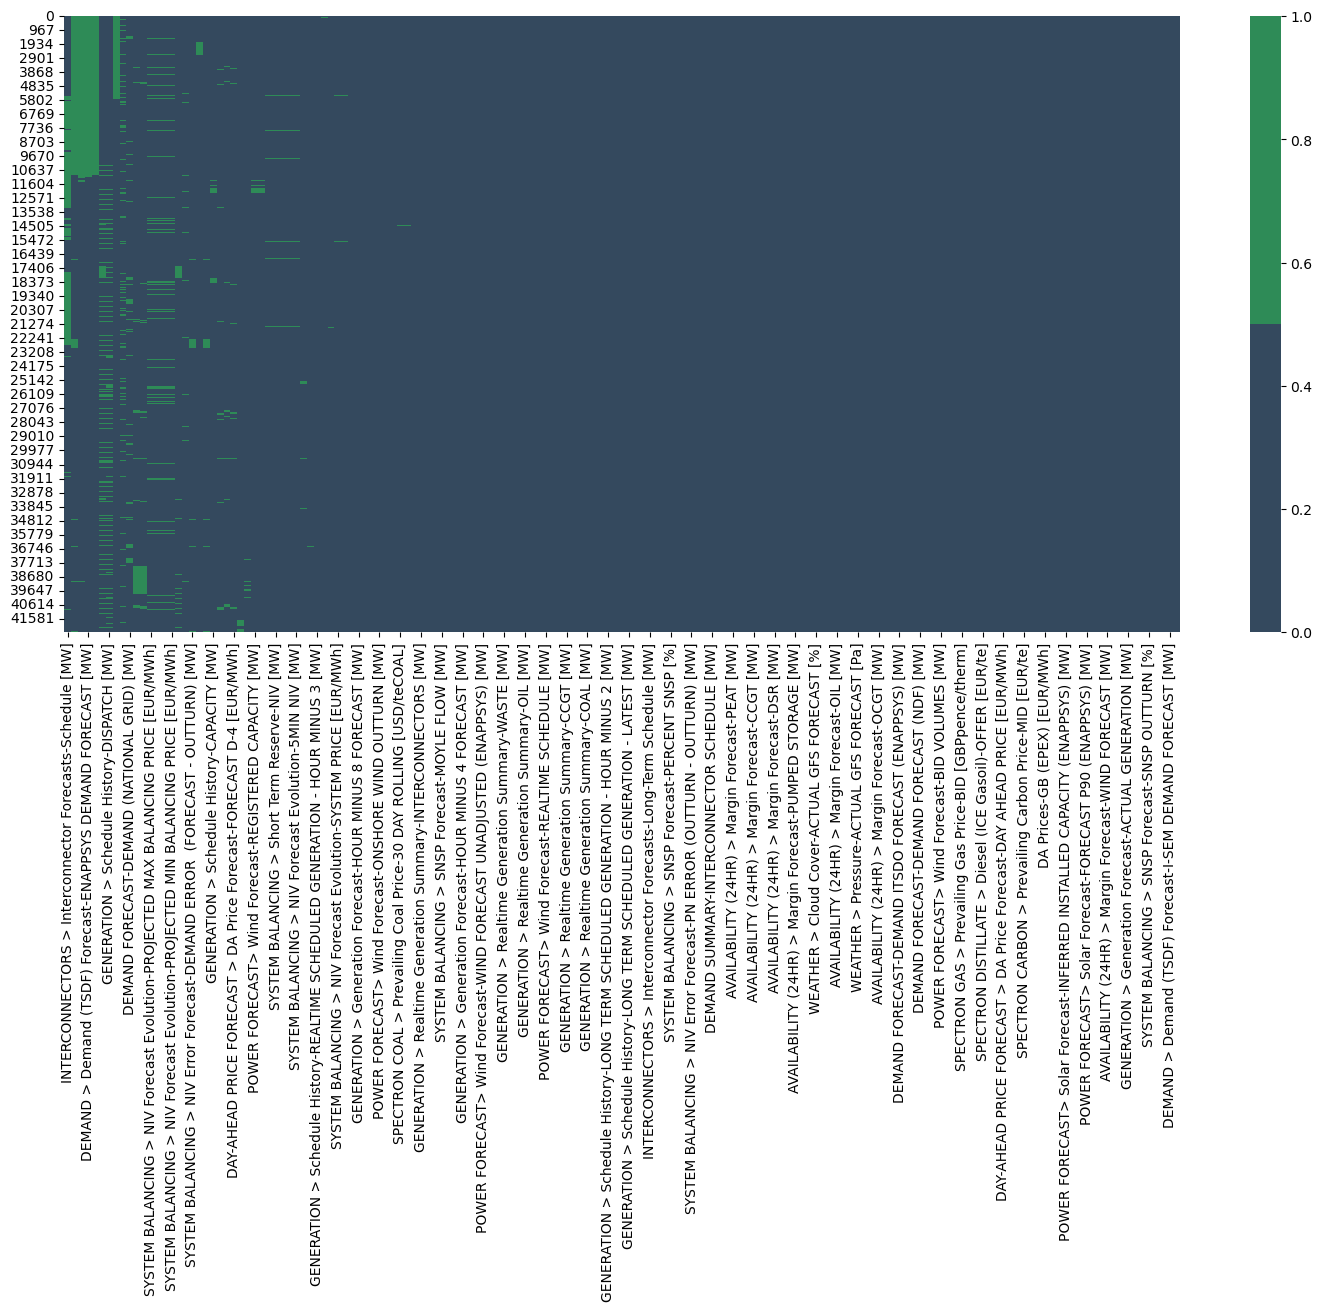

In [62]:
plt.figure(figsize=(18,8))
colours = ['#34495E', 'seagreen'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

**Insight:**
- Columns such as Enappsys Demand Forecast only missing in the beginning periods and can still be important when forecasting in the future.


In [63]:
df = df.ffill()
df = df.bfill()

# 2. Check missing observation in the unseen data

In [64]:
unseen = unseen[df.columns]
null = unseen.isna().sum().sort_values(ascending = False)
# only keep column that has less than two days of missing data.
null_qualify = list(null[null < 96].index)
unseen = unseen[null_qualify]

<AxesSubplot:>

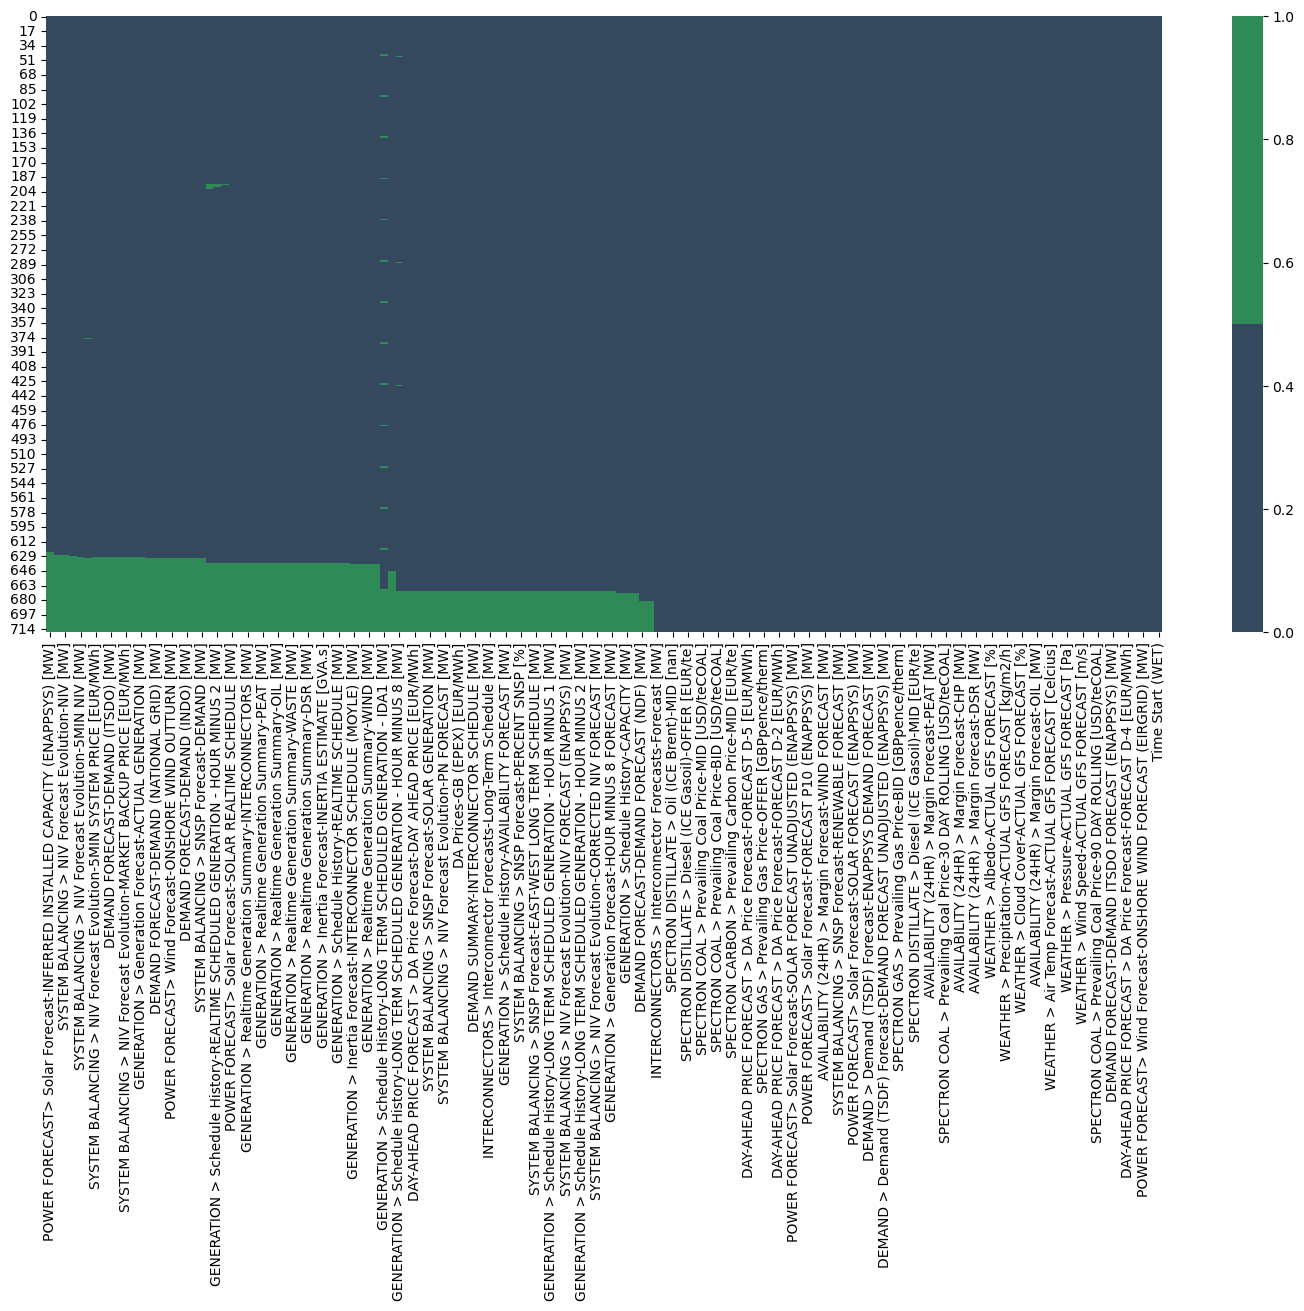

In [65]:
plt.figure(figsize=(18,8))
colours = ['#34495E', 'seagreen'] 
sns.heatmap(unseen.isnull(), cmap=sns.color_palette(colours))

# 3. Shifting data

In [66]:
columns = list(unseen.columns)
columns.append("DA Prices-IRELAND (IE) [EUR/MWh]")
unseen = unseen.ffill()
final_df = pd.concat([df[columns], unseen])


In [67]:
final_df["PREDICTION_TIME"] = final_df["Time Start (WET)"]
final_df["TARGET"] = final_df["DA Prices-IRELAND (IE) [EUR/MWh]"]
forecast_columns = list(final_df.columns[final_df.columns.str.contains("FORECAST")])
forecast_columns.append("PREDICTION_TIME")
forecast_columns.append("TARGET")
actual_columns = list(final_df.drop(forecast_columns, axis = 1).columns)
final_df[actual_columns] = final_df[actual_columns].shift(48)
final_df = final_df.iloc[48:]
final_df.drop("DAY-AHEAD PRICE FORECAST > DA Price Forecast-DAY AHEAD PRICE [EUR/MWh]", axis = 1, inplace = True)
final_df.reset_index(inplace=True)


In [68]:
clean_unseen = final_df.iloc[-718:]
clean_data = final_df.iloc[:-718]

In [69]:
clean_data.to_csv("D:\\SETA\\ENERGY\\data\\processed\\clean_data.csv", index=False)
clean_unseen.to_csv("D:\\SETA\\ENERGY\\data\\processed\\clean_unseen.csv", index=False)
final_df.to_csv("D:\\SETA\\ENERGY\\data\\processed\\processed.csv", index=False)